# Analyzing Third Down Conversion Rate
Common theory in football has it that Third Down Conversion Rate
is a good predictor of the final victor in a given game.
How accurate is this assumption?

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [22]:
#Function to quickly normalize a pandas series.
def norm(s):
    return s/s.abs().max()

#Quick function to scan columns in large dataframes -
#Useful for examining data.
def scan_columns(df,key):
    for c in df.columns:
        if key in c:
            print(c)

In [4]:
#Read the dataframe (from Kaggle, pre-downloaded)
#Kaggle dataset: https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016
#(Takes a while.)
df = pd.read_csv('nflplaybyplay2009to2016/NFL Play by Play 2009-2018 (v5).csv', low_memory=False)

In [5]:
#Chunk up the dataset into a list of dataframes by Game ID
#This lets us iterate through games chronologically!
#(Also takes a while.)
games = [df[df['game_id']==i] for i in df['game_id'].unique()]

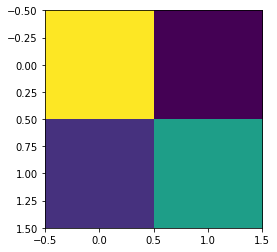

In [6]:
'''
Legend: 
tdcr = Third Down Conversion Rate
tdcr_diff = difference in tdcr between teams
score_diff = difference in score between teams
idxs = shorthand for 'Indexes.'
tdp = Third Down Plays
'''
tdcr_diff = []
score_diff = []
idxs = []

#Init heatmap accumulator (for confusion matrix)
heatmap = np.zeros((2,2))

#March through every game in the games list.
#Process data.
#???
#Profit.
for i, game in enumerate(games):
    #Get all third down plays.
    tdp = game[game['down']==3.0]
    
    #Get the string value indicating home and away team:
    home_team = game['home_team'].values[0]
    away_team = game['away_team'].values[0]
    
    '''
    Get all third down plays where the posessing
    team is the home team. Get the average third 
    down conversion rate for that team. Do the 
    same for the away team.
    '''
    tdp_home = tdp[tdp['posteam']==home_team]
    home_tdcr = tdp_home['third_down_converted'].mean()

    tdp_away = tdp[tdp['posteam']!=home_team]
    away_tdcr = tdp_away['third_down_converted'].mean()
    
    #Grab final score differential (home-away)
    final_score_diff = (game['total_home_score']-game['total_away_score']).values[-1]
    
    #Append the data to the relevant lists!
    tdcr_diff.append(home_tdcr-away_tdcr)
    score_diff.append(final_score_diff)
    #Store game ID for later lookup.
    idxs.append(game['game_id'].values[0])
    
    '''
    Build confusion matrix between tdcr
    and whether the home team won.
    '''
    #Third down conversion rate portions:
    tdcr_idx = None
    if home_tdcr>away_tdcr:
        tdcr_idx = 0
    elif home_tdcr<away_tdcr:
        tdcr_idx = 1
    #elif tdcr_idx == None:
        #print('Equal TDCR.', end='\r')
    
    #Winning team portion:
    win_idx = None
    if final_score_diff > 0:
        win_idx = 0
    elif final_score_diff < 0:
        win_idx = 1
    #elif win_idx == None:
        #print('Tie.', end='\r')
    
    #Increment the appropriate cell:
    if (tdcr_idx != None and win_idx != None):
        heatmap[tdcr_idx, win_idx] += 1
    else:
        pass

    #Progress bar!
    print(np.round((i/len(games))*100), end='\r')
    
plt.imshow(heatmap)

In [8]:
'''
When predicting the winning team solely
by third down conversion differential,
what's the percentage of true positives
and true negatives relative to the whole?
Answer: There's a signal, but it's weak.
'''
(heatmap[0,0]+heatmap[1,1])/sum(heatmap)

0.676159479251424

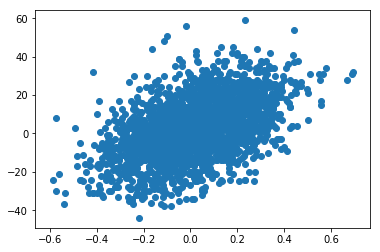

In [9]:
#Make a df from the data, and plot it:
tdcr_score_df = pd.DataFrame(index=idxs, columns=('tdcr_diff','score_diff'))
tdcr_score_df['tdcr_diff'] = tdcr_diff
tdcr_score_df['score_diff'] = score_diff
plt.scatter(tdcr_diff, score_diff)

In [11]:
'''
Perform a basic linear regression on the data:
'''
from sklearn.linear_model import LinearRegression

model = LinearRegression()

tdcr_diff_array = np.expand_dims(tdcr_diff, axis=1)
score_diff_array = np.expand_dims(score_diff, axis=1)

_ = model.fit(tdcr_diff_array,score_diff_array)

'''
How strong is the correlation?
Answer: Weak. But it's there!
'''
model.score(tdcr_diff_array, score_diff_array)

0.23123640516064692

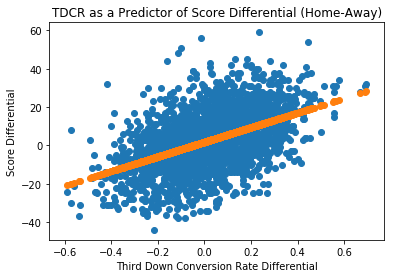

In [15]:
#Let's plot the regression!
plt.scatter(tdcr_diff_array,score_diff_array)
plt.scatter(tdcr_diff_array,model.predict(tdcr_diff_array))
plt.xlabel('Third Down Conversion Rate Differential')
plt.ylabel('Score Differential')
plt.title('TDCR as a Predictor of Score Differential (Home-Away)')
plt.show()

Cool! So there's that answered.

## Stuff below here is exploratory.
No explanation will be provided. Yet.

In [ ]:
'''Redzone Work'''

In [141]:
'''Analysis for ALL Games'''

import more_itertools as mit

#Redzone defined as 20 yards out from touchdown line:
redzone_threshold = 20

ratios = []

for game in games:
    #Define home and away teams:
    home_team = game['home_team'].values[0]
    away_team = game['away_team'].values[0]

    #Define point_change column (score after play - score before play)
    game['pt_chg'] = game['posteam_score_post']-game['posteam_score']

    #Redzone plays defined as plays on the opposing side of the field, within the rdz threshold.
    rdz = game[(game['posteam'] != game['side_of_field'])
               & ((game['yardline_100'] < redzone_threshold) | (game['yardline_100'] > 100-redzone_threshold))]

    #Get index of all rdz plays:
    rdz_idx = rdz.index

    #Chunk into consecutive plays (independent rdz instances):
    rdz_instances = [game.loc[list(group)] for group in mit.consecutive_groups(rdz_idx)]



    '''Log attempted RDZ plays vs completed RDZ plays; also RDZ touchdowns.'''

    rdz_map = {home_team:[0,0], #Format: team -> [attempted, succeeded]
               away_team:[0,0]}
    rdz_touchdown_map = {home_team:[0,0], #Format: team -> [n_rdz_attempts, n_rdz_touchdowns]
                         away_team:[0,0]}

    for i in rdz_instances:
        #Get all pt changes, ignoring pt changes of 1. (Filter for td and field goals)
        indxs = list(i.index.values)
        changes = i[i['pt_chg']!=1]['pt_chg'].values
        #Get the posessing team.
        posteam = i['posteam'].value_counts().index[0] #Posessing team will hold the ball most during play.

        if len(changes) < 1:
            #print(indxs, 'Not an actual rdz play')
            pass
        else:
            #Update rdz maps for attempts
            rdz_map[posteam][0] += 1
            rdz_touchdown_map[posteam][0] += 1

            #If points scored in attempt, update rdz_map:
            if sum(changes) > 0:
                rdz_map[posteam][1] += 1

            #If touchdown scored (6pts) in attempt, update rdz_touchdown_map:
            if 6 in changes:
                rdz_touchdown_map[posteam][1] += 1

    rdz_map, rdz_touchdown_map


    def rdz_ratio(rdz_map, key):
        attempted, completed = rdz_map[key]
        return completed/attempted

    #scan_columns(game, 'sc')
    home_score = game['total_home_score'].values[-1]
    away_score = game['total_away_score'].values[-1]

    winning_team = [home_team, away_team][np.argmax([home_score>away_score, away_score>home_score])]
    losing_team = [home_team, away_team][np.argmin([home_score>away_score, away_score>home_score])]
    
    #Winning team rdz touchdown ratio vs losing team rdz touchdown ratio
    winning_rdz_td_relative_ratio = np.inf
    try:
        winning_rdz_td_relative_ratio = rdz_ratio(rdz_touchdown_map, winning_team)/rdz_ratio(rdz_touchdown_map, losing_team)
    except:
        pass
    ratios.append(winning_rdz_td_relative_ratio)
    print(winning_team)

/Users/mgbvox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


PIT
MIN
NO
DAL
NYJ
IND
DEN
PHI
BAL
ATL
SF
SEA
NYG
GB
NE
SD
ATL
MIN
WAS
HOU
NO
NYJ
OAK
ARI
CIN
SF
BUF
BAL
DEN
CHI
NYG
IND
BAL
NYJ
DET
JAC
MIN
NE
NYG
PHI
GB
NO
CHI
CIN
SD
DEN
IND
DAL
CHI
CIN
HOU
IND
JAC
NYG
NE
WAS
MIA
NO
DEN
SF
PIT
MIN
MIN
PHI
DAL
PIT
CAR
CLE
NYG
CIN
ATL
SEA
DEN
ARI
IND
MIA
HOU
GB
JAC
MIN
NO
PIT
CAR
KC
OAK
ARI
NE
BUF
ATL
DEN
NE
IND
PIT
SD
HOU
GB
NYJ
BUF
NO
DAL
CIN
ARI
PHI
BAL
HOU
CHI
DAL
STL
IND
PHI
MIA
SD
TEN
CAR
MIN
NO
ATL
ARI
CIN
IND
JAC
NE
TB
NO
SEA
SD
TEN
DAL
PIT
SF
CAR
WAS
TEN
NO
CIN
JAC
MIA
MIN
KC
GB
ARI
SD
IND
BAL
MIA
IND
NO
NYG
MIN
KC
JAC
DAL
DET
GB
ARI
SD
OAK
NE
PHI
TEN
GB
DAL
DEN
BUF
ATL
CIN
SEA
IND
NYJ
PHI
SF
SD
TEN
MIN
BAL
NO
NYJ
PHI
MIA
NO
OAK
DEN
CAR
CHI
CIN
IND
JAC
SD
SEA
NYG
ARI
GB
CLE
HOU
BUF
MIN
NE
NYJ
IND
MIA
GB
BAL
NO
TEN
WAS
SD
PHI
SF
IND
DAL
HOU
CLE
ATL
NE
TEN
ARI
OAK
SD
PIT
BAL
PHI
TB
CAR
NYG
SD
ATL
PIT
TB
NE
CAR
HOU
CIN
CLE
GB
ARI
SF
PHI
NYJ
DAL
CHI
BUF
CAR
ATL
SF
MIN
PIT
HOU
CHI
CLE
KC
GB
SD
BAL
DAL
TEN
NYJ
NO
TB
PIT
CHI
NYG
TEN
JAC
MIA
NE
HOU
G

In [144]:
#SAVE WORK - that took a while.
np.save('ratios', np.array(ratios))

In [39]:
ratios = np.load('ratios.npy')

In [37]:
def game_end_stats(game):
    home_team = game['home_team'].values[0]
    away_team = game['away_team'].values[0]
    home_score = game['total_home_score'].values[-1]
    away_score = game['total_away_score'].values[-1]
    winner_score = max(home_score,away_score)
    loser_score = min(home_score,away_score)
    winning_team = [home_team, away_team][np.argmax([home_score>away_score, away_score>home_score])]
    losing_team = [home_team, away_team][np.argmin([home_score>away_score, away_score>home_score])]
    return {
        'winner':winning_team,
        'loser':losing_team,
        'home':home_team,
        'away':away_team,
        'home_score':home_score,
        'away_score':away_score,
        'winner_score':winner_score,
        'loser_score':loser_score,
        'score_diff':winner_score-loser_score
    }


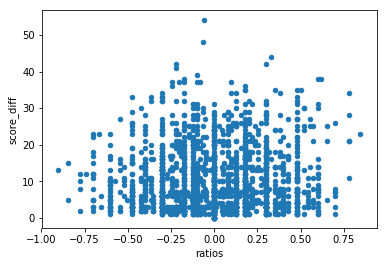

In [84]:
game = games[0]


res = [(np.log10(ratios[i]),game_end_stats(game)['score_diff']) 
       for i,game in enumerate(games) 
       if ratios[i]<np.inf and ratios[i]>0]
res = pd.concat([pd.Series(i) for i in list(zip(*res))],axis=1).rename(columns={0:'ratios',1:'score_diff',2:'tdcr_diff'})
#res = res[(res['ratios']<np.inf) & res['ratios']>np.inf]
res.plot.scatter('ratios','score_diff')
plt.show()

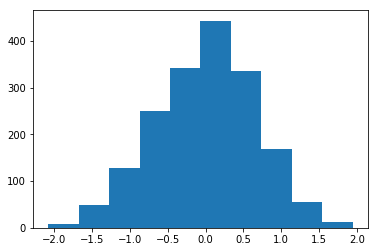

In [85]:
plt.hist([np.log(i) for i in ratios if i < 1000 and i > 0])
plt.show()

In [90]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

x = np.expand_dims(res['ratios'].values,axis=1)
y = res['score_diff'].values

In [93]:
model.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

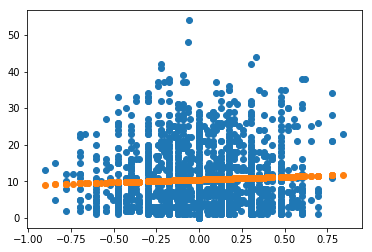

In [102]:
y_pred = model.predict(x)
plt.scatter(x,y)
plt.scatter(x,y_pred)

In [138]:
scan_columns(df,'home_sc')

total_home_score


In [139]:
time_stats = [game[['game_seconds_remaining',
                    'score_differential',
                    'total_home_score',
                    'total_away_score'
                   ]].dropna() for game in games]

/Users/mgbvox/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


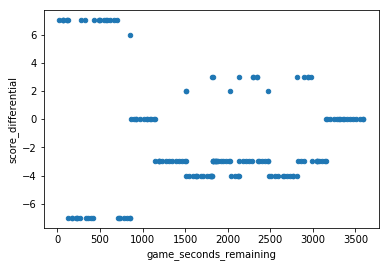

In [149]:
g = time_stats[35]
g = g.reset_index(drop=True)
g = g.loc[:np.argmin(g['game_seconds_remaining'])]
g.plot.scatter('game_seconds_remaining','score_differential')

In [150]:
g['total_away_score'].diff().mean()

0.19254658385093168

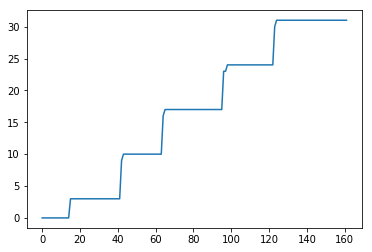

In [151]:
g['total_away_score'].plot()

0.19254658385093168

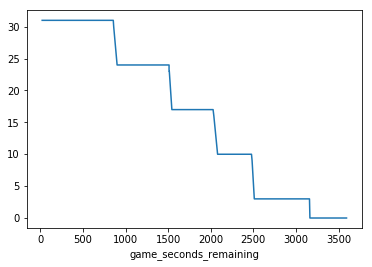

In [154]:
g = g.set_index(g['game_seconds_remaining'])
g['total_away_score'].plot()
g['total_away_score'].diff().mean()

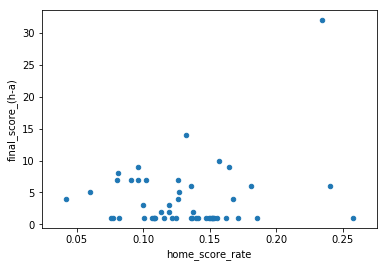

In [176]:
score_pace_games  =  [(g['total_away_score'].diff().mean(),
                       g['total_home_score'].diff().mean(),
                       g['total_away_score'].values[-1],
                       g['total_home_score'].values[-1],
                       g['score_differential'].values[-1]
                       ) for g in games]
score_pace_games = pd.concat([pd.Series(i) for i in list(zip(*score_pace_games))],axis=1)
score_pace_games = score_pace_games.rename(columns={
    0:'away_score_rate',
    1:'home_score_rate',
    2:'away_final_score',
    3:'home_final_score',
    4:'final_score_(h-a)'
}).dropna()
rate_home_wins = score_pace_games[score_pace_games['final_score_(h-a)']>0][['home_score_rate','final_score_(h-a)']]
rate_home_wins.plot.scatter('home_score_rate','final_score_(h-a)')

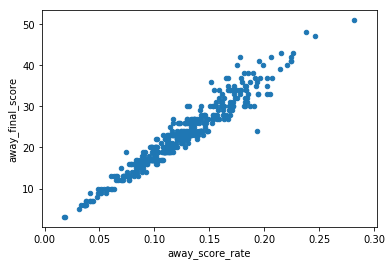

In [179]:
#'final_score_(h-a)'
score_pace_games.plot.scatter('away_score_rate','away_final_score')

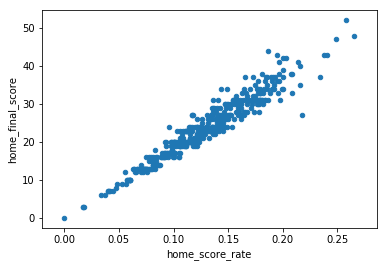

In [181]:
score_pace_games.plot.scatter('home_score_rate','home_final_score')